# Modeling Yield Curve Dynamics Using PCA and AR-GARCH

This project analyzes daily U.S. Treasury yield data across multiple maturities to study yield-curve dynamics and interest-rate risk.  
Principal Component Analysis (PCA) is used to extract latent yield-curve factors (level, slope, curvature), which are then modeled as time-series processes using AR-GARCH to capture conditional volatility and risk dynamics.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("merged.csv")
df.head()

,observation_date,DGS1,DGS2,DGS5,DGS10,DGS30
0,2021-01-26,0.09,0.11,0.42,1.05,1.80
1,2021-01-27,0.09,0.12,0.41,1.04,1.79
2,2021-01-28,0.08,0.12,0.42,1.07,1.81
3,2021-01-29,0.10,0.11,0.45,1.11,1.87
4,2021-02-01,0.08,0.11,0.42,1.09,1.84


## Data Description

The dataset consists of daily U.S. Treasury zero-coupon yields for five maturities:  
1Y, 2Y, 5Y, 10Y, and 30Y (sourced from FRED).

These yields represent constant-maturity interest rates rather than bond prices.  
Due to strong cross-maturity correlation, the yield curve is well-suited for factor-based modeling.


In [5]:
df.set_index("observation_date",inplace=True)

In [6]:
df.describe()

,DGS1,DGS2,DGS5,DGS10,DGS30
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,3.354960,3.242088,3.230976,3.407680,3.724928
std,1.876949,1.637896,1.286835,1.125437,1.038531
min,0.040000,0.090000,0.410000,1.040000,1.690000
25%,1.975000,2.530000,2.760000,2.750000,2.920000
50%,4.090000,3.900000,3.750000,3.880000,4.030000
75%,4.807500,4.400000,4.130000,4.260000,4.607500
max,5.490000,5.190000,4.950000,4.980000,5.110000


In [8]:
df.isna().sum()

DGS1     55
DGS2     55
DGS5     55
DGS10    55
DGS30    55
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isna().sum()

DGS1     0
DGS2     0
DGS5     0
DGS10    0
DGS30    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 2021-01-26 to 2026-01-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DGS1    1250 non-null   float64
 1   DGS2    1250 non-null   float64
 2   DGS5    1250 non-null   float64
 3   DGS10   1250 non-null   float64
 4   DGS30   1250 non-null   float64
dtypes: float64(5)
memory usage: 58.6+ KB


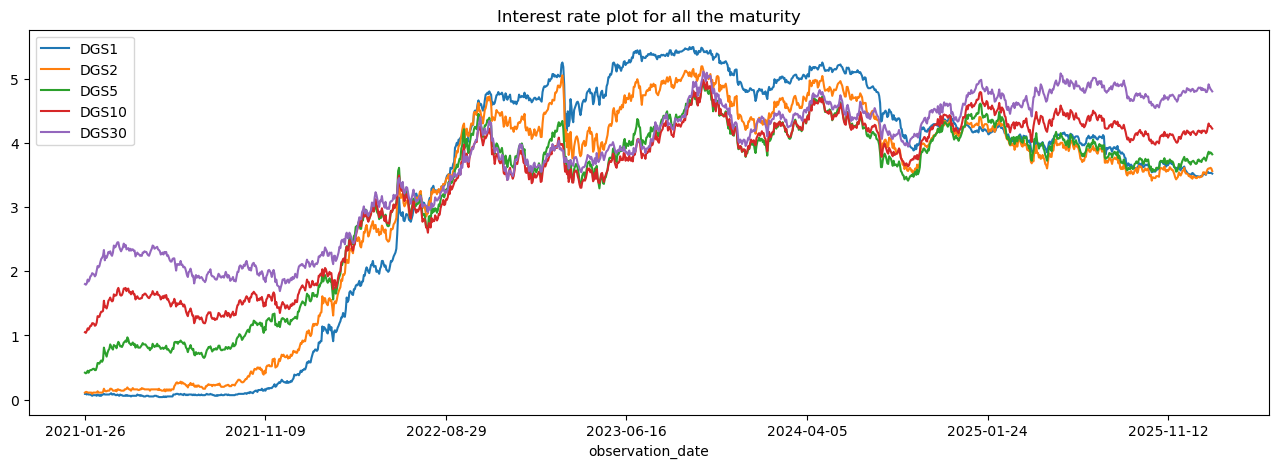

In [17]:
df.plot(figsize = (16,5))
plt.title("Interest rate plot for all the maturity")
plt.show()

In [21]:
df_returns = df.diff().dropna()
df_returns.head()

,DGS1,DGS2,DGS5,DGS10,DGS30
observation_date,,,,,
2021-01-27,0.00,0.01,-0.01,-0.01,-0.01
2021-01-28,-0.01,0.00,0.01,0.03,0.02
2021-01-29,0.02,-0.01,0.03,0.04,0.06
2021-02-01,-0.02,0.00,-0.03,-0.02,-0.03
2021-02-02,0.00,0.00,0.03,0.03,0.03


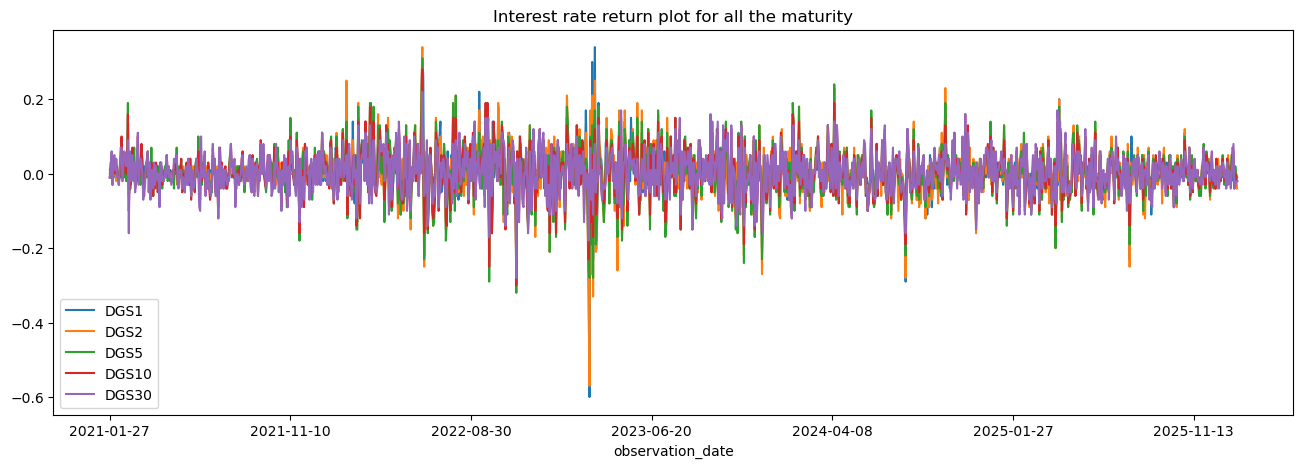

In [22]:
df_returns.plot(figsize = (16,5))
plt.title("Interest rate return plot for all the maturity")
plt.show()

## Yield Changes

Since interest rates are non-stationary in levels, the analysis is conducted on yield changes rather than raw yields.  
Yield changes capture short-term movements in interest rates and are appropriate inputs for time-series and volatility modeling.


In [28]:
Scaler = StandardScaler()
df_scaled = Scaler.fit_transform(df_returns)
df_scaled[:5]

array([[-0.05135571,  0.10709849, -0.18704926, -0.20258319, -0.22174811],
       [-0.23836237, -0.04087276,  0.10700301,  0.44371669,  0.31465613],
       [ 0.32265761, -0.18884402,  0.40105527,  0.60529166,  1.02986179],
       [-0.42536903, -0.04087276, -0.48110152, -0.36415816, -0.57935094],
       [-0.05135571, -0.04087276,  0.40105527,  0.44371669,  0.49345755]])

## Principal Component Analysis (PCA)

Yields across maturities are highly correlated, making direct multivariate modeling inefficient.  
PCA is used to reduce dimensionality and extract orthogonal risk factors that explain most of the variation in the yield curve.

The first three principal components are typically interpreted as:
- **Level**: Parallel shifts of the yield curve
- **Slope**: Steepening or flattening
- **Curvature**: Changes in the mid-term relative to short and long rates


In [29]:
pca = PCA()
pca.fit(df_scaled)

PCA()

In [30]:
explained_var = pd.Series(
    pca.explained_variance_ratio_,
    index=df_returns.columns
)
explained_var

DGS1     0.813881
DGS2     0.145790
DGS5     0.028461
DGS10    0.009224
DGS30    0.002644
dtype: float64

In [31]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_returns.columns,
    columns=[f'PC{i+1}' for i in range(len(df_returns.columns))]
)

loadings

,PC1,PC2,PC3,PC4,PC5
DGS1,0.408943,-0.591965,0.659032,-0.218759,-0.012798
DGS2,0.455872,-0.387868,-0.403393,0.678530,0.136420
DGS5,0.484397,0.010865,-0.460800,-0.478801,-0.568907
DGS10,0.471274,0.337755,-0.081329,-0.321529,0.744196
DGS30,0.410131,0.620435,0.428952,0.398885,-0.322092


In [32]:
pca_factors = pd.DataFrame(
    pca.transform(df_scaled),
    index=df_returns.index,
    columns=[f"PC{i+1}" for i in range(len(df_returns.columns))]
)
pca_factors_3 = pca_factors[["PC1", "PC2", "PC3"]]
pca_factors_3.head()

,PC1,PC2,PC3
observation_date,,,
2021-01-27,-0.249202,-0.219175,-0.069499
2021-01-28,0.273885,0.503209,-0.091022
2021-01-29,0.947766,0.730004,0.496548
2021-02-01,-0.834856,-0.220016,-0.261050
2021-02-02,0.566130,0.506637,-0.026581


## PCA Results

The first three principal components explain the majority of total yield-curve variance.  
These components correspond closely to the economic notions of level, slope, and curvature, validating the factor-based representation of interest-rate risk.


In [34]:
pca_factors_3.shape

(1249, 3)

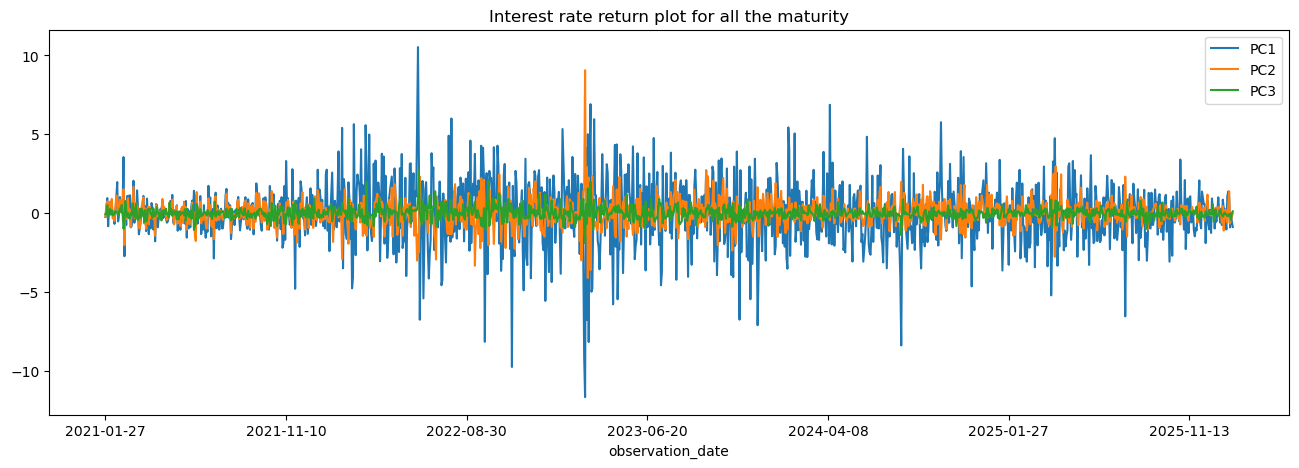

In [35]:
pca_factors_3.plot(figsize = (16,5))
plt.title("Interest rate return plot for all the maturity")
plt.show()

## Time-Series Modeling of PCA Factors

After dimensionality reduction, each PCA factor is treated as an independent time series.  
Autoregressive models are used to capture mean dynamics, while conditional heteroskedasticity is examined to assess volatility clustering.


In [39]:
from statsmodels.tsa.arima.model import ARIMA

residuals_df = pd.DataFrame(index=pca_factors_3.index)

for pc in ["PC1", "PC2", "PC3"]:
    res = ARIMA(pca_factors_3[pc], order=(1,0,0)).fit()
    residuals_df[f"res_{pc}"] = res.resid

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

In [40]:
import sys
!{sys.executable} -m pip install arch

In [42]:
from statsmodels.stats.diagnostic import het_arch

for col in residuals_df.columns:
    lm_stat, p_val, _, _ = het_arch(residuals_df[col], nlags=10)
    print(col, "p-value:", p_val)

res_PC1 p-value: 7.436328416386671e-23
res_PC2 p-value: 3.932661848504694e-15
res_PC3 p-value: 4.302060112256418e-14


## Volatility Modeling

ARCH tests indicate strong conditional heteroskedasticity in the PCA factor residuals.  
This motivates the use of GARCH-type models to capture time-varying volatility, which is a well-documented feature of interest-rate movements.


In [48]:
from arch import arch_model

garch_results = {}

for pc in ["PC1", "PC2", "PC3"]:
    series = pca_factors_3[pc]

    model = arch_model(
        series,
        mean="AR",
        lags=1,
        vol="GARCH",
        p=1,
        q=1,
        dist="t"
    )

    res = model.fit(disp="off")
    garch_results[pc] = res

    print(f"\n==== {pc} ====")
    print(res.summary())


==== PC1 ====
                              AR - GARCH Model Results                              
Dep. Variable:                          PC1   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -2492.07
Distribution:      Standardized Student's t   AIC:                           4996.15
Method:                  Maximum Likelihood   BIC:                           5026.92
                                              No. Observations:                 1248
Date:                      Thu, Jan 29 2026   Df Residuals:                     1246
Time:                              13:58:20   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for pc in ["PC1", "PC2", "PC3"]:
    std_resid = garch_results[pc].std_resid

    std_resid = std_resid.replace([np.inf, -np.inf], np.nan).dropna()
    lb_test = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)

    print(f"\n{pc}")    
    print(lb_test)

## Model Diagnostics

Standardized residuals from the AR-GARCH models are tested for remaining autocorrelation using the Ljung–Box test.  
The absence of significant autocorrelation indicates that both mean and volatility dynamics are adequately captured by the model.


In [54]:
pcs = ["PC1", "PC2", "PC3"]

mean_forecast = {}
var_forecast = {}

for pc in pcs:
    fcast = garch_results[pc].forecast(horizon=10)

    mean_forecast[pc] = fcast.mean.iloc[-1]       # Series
    var_forecast[pc]  = fcast.variance.iloc[-1]   # Series

mean_df = pd.DataFrame(mean_forecast)
var_df  = pd.DataFrame(var_forecast)

In [55]:
mean_df.head()

,PC1,PC2,PC3
h.01,0.004865,-0.002038,-0.017330
h.02,-0.017494,-0.001704,-0.013722
h.03,-0.016931,-0.001712,-0.013825
h.04,-0.016945,-0.001712,-0.013822
h.05,-0.016945,-0.001712,-0.013822


In [56]:
var_df.head()

,PC1,PC2,PC3
h.01,1.018749,0.466713,0.061928
h.02,1.029076,0.483976,0.064965
h.03,1.038750,0.499732,0.067863
h.04,1.048408,0.514347,0.070673
h.05,1.058052,0.527904,0.073397


In [57]:
vol_forcast = np.sqrt(var_df)
vol_forcast.head()

,PC1,PC2,PC3
h.01,1.009331,0.683164,0.248853
h.02,1.014434,0.695684,0.254882
h.03,1.019191,0.706917,0.260505
h.04,1.023918,0.717180,0.265843
h.05,1.028617,0.726570,0.270918


In [60]:
annual_vol = vol_forcast*np.sqrt(252)
annual_vol.head()

,PC1,PC2,PC3
h.01,16.022633,10.844891,3.950422
h.02,16.103637,11.043638,4.046124
h.03,16.179149,11.221963,4.135394
h.04,16.254194,11.384879,4.220134
h.05,16.328782,11.533943,4.300693


In [63]:
from scipy.stats import norm

z_95 = norm.ppf(0.05)
VaR_95 = z_95 * vol_forcast.iloc[0]
VaR_95

PC1   -1.660202
PC2   -1.123705
PC3   -0.409327
Name: h.01, dtype: float64

## Conclusion

This project demonstrates how yield-curve dynamics can be modeled using a factor-based approach.  
By combining PCA with AR-GARCH models, the analysis captures both the structural and time-varying risk properties of interest rates.

Such frameworks are widely used in fixed-income risk management, bond portfolio construction, and interest-rate forecasting.
